In [1]:
# coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller
import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import os
import pickle
torch.set_default_tensor_type(torch.DoubleTensor)
import warnings
warnings.filterwarnings('ignore')

In [2]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([0.5], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init], requires_grad=True))
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        # self.theta = Parameter(torch.tensor([0.2], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        return torch.pow(X,2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - self.act(self.alpha)*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha
    
    def update_beta(self, b):
        self.beta = Parameter(torch.tensor([b], requires_grad=True))


In [84]:
class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., E_ratio_init=3., I_init=41, R_init=2., D_init=0., param={}):
        super(SEIR_model, self).__init__()
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        if param!={}:
            len_param=len(param['beta'])
            self.beta_save = param['beta']
            self.gamma_2_save = param['gamma_2']
            self.alpha_save = param['alpha']
            self.theta_save = param['theta']
            for i in range(len_param):
                beta = self.beta_save[i]
                gamma_2 = self.gamma_2_save[i]
                alpha = self.alpha_save[i]
                theta = self.theta_save[i]
                self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha))
            if self.date_len>len_param:
                for i in range(len_param, self.date_len):
                    if len_param>=1:
                        beta = self.beta_save[len_param-1]
                        gamma_2 = self.gamma_2_save[len_param-1]
                        alpha = self.alpha_save[len_param-1]
                        theta = self.theta_save[len_param-1]
                        self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha)) 
                    else:
                        self.SEIR_cells.append(SEIR_cell(self.N)) 
        else:
            for i in range(self.date_len):
                self.SEIR_cells.append(SEIR_cell(self.N)) 

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            if i == self.date_len-1: # we cannot update the last beta with grad
                self.beta = beta_cur
                self.SEIR_cells[i].update_beta(beta_cur)
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, param={}):
        check_positive_replace = lambda x,y:[yi if xi<=0 else xi for xi,yi in zip(x,y) ]
        # check_positive_replace 
        N_cur_list=[self.N]*pred_date_len
        beta_list=[self.beta]*pred_date_len
        gamma_2_list=[self.gamma_2]*pred_date_len
        theta_list=[self.theta]*pred_date_len
        alpha_list=[self.alpha]*pred_date_len
        if param=={}:
            N_cur=N_cur_list
            beta=beta_list
            gamma_2=gamma_2_list
            theta=theta_list
            alpha=alpha_list
        else:
            N_cur=N_cur_list
            for k in param.keys():
                if len(param[k])==1:
                    param[k]=param[k]*pred_date_len
            beta=check_positive_replace(param['beta'],[0.]*len(param['beta']))
            gamma_2=check_positive_replace(param['gamma_2'],gamma_2_list)
            theta=check_positive_replace(param['theta'],theta_list)
            alpha=check_positive_replace(param['alpha'],[0.]*len(param['alpha']))
        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur[i],beta[i],gamma_2[i],theta[i],alpha[i]))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor



    def beta_pred(self, beta_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[beta_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['beta']
        param_dict={}
        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            print("data:",data)
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1]  
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA模型
            param_dict[param]=model.forecast(2)[0]
            print(param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(dif,0,-1):
                    dif_data_list[i-1]=np.append(dif_data_list[i-1],dif_data_list[i][-2:]+dif_data_list[i-1][-2:])
                param_dict[param]=dif_data_list[0][-2:]
        # update beta by arima
        param_dict['beta'][0] = check_positive(param_dict['beta'][0])
        # param_dict['beta'][1] = check_positive(param_dict['beta'][1])
        self.SEIR_cells[-1].update_beta(param_dict['beta'][0])
        
        return param_dict['beta']

    def param_pred(self,beta_list,gamma_2_list,theta_list,alpha_list,pred_date_len):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[gamma_2_list,theta_list,alpha_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['gamma_2','theta','alpha']
        param_dict={}

        param_dict['beta'] = self.beta_pred(beta_list[:-1])

        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1] 
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            model.summary2() #给出一份模型报告
            param_dict[param]=model.forecast(pred_date_len)[0]
            print(param+"的预测值为"，param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(1,dif+1,1):
                    for j in range(pred_date_len):
                        dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][j-pred_date_len]+ dif_data_list[-i-1][-1])
                param_dict[param]=dif_data_list[0][-pred_date_len:]
        for k,v in param_dict.items():
            param_dict[k]= [check_positive(a)for a in param_dict[k]]
        return param_dict
    def exponential_decay(self,t, init=0.99, m=8, finish=0.95):
        alpha = np.log(init / finish) / m
        l = - np.log(init) / alpha
        decay = np.exp(-alpha * (t + l))
        return decay   
    def exp_param_pred(self,beta,pred_len=5):
        temp=[]
        for i in range(pred_len):
            temp.append(self.exponential_decay(i)*beta)
        return temp

SyntaxError: invalid character in identifier (<ipython-input-84-249e30bc0211>, line 218)

In [44]:
def plot_SEIRD(data, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    # plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    # plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')

    for a,b in zip(merge_time, I):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    # for a,b in zip(merge_time, S):
    #     plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

def plot_param(model,city_name,data,xlen=10):
    T_name = 'time'
    time_val = data[T_name].values
    plt.figure(figsize=(xlen, 10))
    # pd.to_datetime()
    format_datetime = lambda x :f'0{x.date().month}-{x.date().day}' if x.date().month<10 else f'{x.date().month}-{x.date().day}'
    dates_list = [format_datetime(pd.to_datetime(d)) for d in time_val]
    beta = []
    gamma_2 = []
    theta = []
    alpha = []
    omega = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        omega.append((model.SEIR_cells[i].theta.detach().numpy()[0])*0.)

    print('beta:',beta)
    print('gamma_2:',gamma_2)
    print('theta:',theta)
    print('alpha:',alpha)
    print('omega:',omega)
    plot_title = ['beta-感染率','gamma_2-治愈率','theta-死亡率','alpha-(疑似->感染)率','omega-疑似解除率']
    plot_list_sqrt = [beta,gamma_2,theta,alpha,omega]
    plot_list=[np.square(p) for p in plot_list_sqrt]
    colors=['blue','darkgreen','darkorange','red','purple']
    for i in range(len(colors)):
        plt.plot(dates_list[:len(beta)], plot_list[i],color=colors[i],label=plot_title[i],marker='x')
    for a, b in zip(range(len(beta)), beta):
        plt.annotate('%.4f' % (b), xy=(a, b), xytext=(-2, 2), textcoords='offset points', color=colors[0])
    plt.legend()
    title = 'Param changing process-'+city_name
    plt.title(title)
    plt.show()

def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed,acc_cured,acc_pred_cured,xlen=10, city=u'武汉', pred_date_len=0):
    T_name = 'time'
    plt.figure(figsize=(xlen, 10))
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)

    '''
    意思是在一个2行2列共4个子图的图中，定位第1个图来进行操作（画图）。
    最后面那个1表示第1个子图。那个数字的变化来定位不同的子图
    '''
    #第一行第一列图形
    ax1 = plt.subplot(2,1,1)
    #第一行第二列图形
    ax2 = plt.subplot(2,1,2)
    #第二行
    #选择ax1
    plt.sca(ax1)
    #绘制红色曲线
    plt.plot(time_val, accumulated_confirmed, color='red', label='累计确诊人数', marker='x')
    plt.plot(merge_time, accumulated_pred_confirmed, color='blue', label='预测的累计确诊人数', marker='x')
    for a, b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    
    plt.sca(ax2)
    #绘制红色曲线
    plt.plot(time_val, acc_cured, color='red', label='累计治愈人数', marker='x')
    plt.plot(merge_time, acc_pred_cured, color='blue', label='预测的累计治愈人数', marker='x')
    for a, b in zip(merge_time, acc_pred_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, acc_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'累计预测')
    plt.show()
    return
    
def plot_daily_new(data, new_confirm, pred_new_confirm, new_cured,pred_new_cured,xlen=10, city=u'武汉', pred_date_len=0):
    plt.figure(figsize=(xlen, 10))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D'))
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    ax1 = plt.subplot(2,1,1)
    #第一行第二列图形
    ax2 = plt.subplot(2,1,2)
    #第二行
    #选择ax1
    plt.sca(ax1)
    #绘制红色曲线
    plt.plot(time_val, new_confirm, color='red', label='新增确诊人数', marker='x')
    plt.plot(merge_time, pred_new_confirm, color='blue', label='预测的新增确诊人数', marker='x')
    for a, b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, new_confirm):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    
    plt.sca(ax2)
    #绘制红色曲线
    plt.plot(time_val, new_cured, color='red', label='新增治愈人数', marker='x')
    plt.plot(merge_time, pred_new_cured, color='blue', label='预测的新增治愈人数', marker='x')
    for a, b in zip(merge_time, pred_new_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, new_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'新增预测')
    plt.show()
    return

def cal_acc_confirm(I,R,D):
    return I+R+D

def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm

def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

def save_param(model, model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    beta = []
    theta = []
    gamma_2 = []
    alpha = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
    param={'beta':beta,'theta':theta,'gamma_2':gamma_2,'alpha':alpha}
    with open(save_path + 'param.pkl', 'wb') as f:
        pickle.dump(param, f, pickle.HIGHEST_PROTOCOL)

def load_param(model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    with open(save_path + 'param.pkl', 'rb') as f:
        return pickle.load(f)

def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate

def train(data, model_city_date_path, lr_init=0.01, N=1e7, I_init=1e-6, R_init=1e-6 / 2., D_init=1e-6 / 6., cured_ratio=20., dead_ratio=20.,
          param={}, features=['I', 'cured', 'dead'], max_epoches=6000):
    model_pt = os.path.join(model_city_date_path, 'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat, dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len, pred_date_len=10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, param=param)

    lr = lr_init
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    loss_list=[]
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S, I, E, R, D, beta, gamma_2 = model(model_inp.float())
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_confirmed = I+R+D
        
        I_gt_tensor = Input[:, 0]
        recovered_gt_tensor = Input[:, 1]
        dead_gt_tensor = Input[:, 2]
        confirmed_gt_tensor=I_gt_tensor+recovered_gt_tensor+dead_gt_tensor

        loss = (loss_fn(pred_confirmed, confirmed_gt_tensor) + cured_ratio*loss_fn(pred_recovered, recovered_gt_tensor) + dead_ratio*loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_I, I_gt_tensor))/(dead_ratio+cured_ratio+2.)
        print("Loss: {}".format(loss))
        loss_list.append(loss)
        if loss < loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(epoch_step,lr,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:", loss_min)
    save_param(model,model_city_date_path)
    return S, I, E, R, D, loss_list

    
def load_model_predict(model_city_date_path, data, param_pred=True,city_name='深圳',c='confirmed', return_new_C_R=False, features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)
#     print(confirm_origin)
#   使用原始数据得到的
    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha,pred_date_len)
        param['beta']=model.exp_param_pred(beta[-1],pred_date_len)
        
        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)
    S_pred_total = np.concatenate((S_pred_old,S_pred_new),axis=0)
    E_pred_total = np.concatenate((E_pred_old,E_pred_new),axis=0)

    plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)
    
    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    cured_origin=np.array(data['cured'])
    new_cured_orgin=np.diff(cured_origin)
    new_cured_pred=np.diff(R_pred_total)
    plot_daily_acc(data, confirm_origin, confirm_pred,cured_origin,R_pred_total,city=city_name, pred_date_len=pred_date_len)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total
    
    plot_daily_new(data, new_confirm, new_confirm_pred_total,new_cured_orgin,new_cured_pred,city=city_name, pred_date_len=pred_date_len)
    print('新增治愈：',new_cured_pred)
    print('新增确诊：',new_confirm_pred_total)
    if  return_new_C_R:
        return model,new_confirm_pred_total,new_cured_pred
#     print("!!!!!!\nN:\n",S_pred_total+E_pred_total+I_pred_total+R_pred_total+D_pred_total)
    return model

def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['I/cured']=data['I']/data['cured']
    data['I/dead']=data['I']/data['dead']

    if 'nation' in path:    #全国有个E
        data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    return data

def train_with_city_data(data, N, date, cityname='深圳', lr_init=0.01, max_epoches=2000,is_train=True,load_param_save=False,param_path=''):
    city_pinyin = {'北京':'beijing','重庆':'chongqing','上海':'shanghai','深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    cured_ratio = float(data['I'].mean()/data['cured'].mean()) if data['cured'].mean()!=0 else 50.
    dead_ratio = float(data['I'].mean()/data['dead'].mean()) if data['dead'].mean()!=0 else 50.
    print('cured_ratio:',cured_ratio)
    print('dead_ratio:',dead_ratio)
    param={}
    if load_param_save:
        if param_path=='':
            param_path=model_city_date_path
        param = load_param(param_path)
    print(param)
#     if loss_type='cure':
#         cured_ratio*=2
#         dead_ratio\=
    #train里面会保存模型
    if is_train:
        S,I,E,R,D,loss_list = train(data, model_city_date_path, lr_init=lr_init, N=N, I_init=I_init, R_init=R_init, D_init=D_init, cured_ratio=cured_ratio,dead_ratio=dead_ratio, features=features, max_epoches=max_epoches,param=param)
        plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')
    return model_city_date_path
#read data

In [164]:
# import datetime as dt
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]

time='0220'
# yesterday='02-13'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
# param_paths_yes=['models/'+'hubei/'+yesterday,'models/'+'wuhan/'+yesterday,'models/'+'shenzhen/'+yesterday,'models/'+'china/'+yesterday]

cured_ratio: 6.875341139184787
dead_ratio: 35.216323686152336
{'beta': [0.6879206700356789, 0.7312271644850583, 0.7588744658465173, 0.8215862768744163, 0.8377355949390787, 0.8570571760223165, 0.7945325982967637, 0.7192847273910175, 0.5961865452591539, 0.5757794808805378, 0.5683813453952606, 0.5531127661672857, 0.539753416736954, 0.5363117547646424, 0.5332716220319074, 0.5303961978532961, 0.524393733110829, 0.5228182971477996, 0.5209292953677228, 0.5007694340434611, 0.3616334458410046, 0.4239503063936846, 0.25472561071704614, 0.22260389429202693, 0.20108361532661642, 0.2010637738683674, 0.1908926863891286, 0.161039345277728, 0.09898230581872716, 0.11169516733186642, 0.11169426302408347], 'theta': [0.10707510441724973, -0.126560596042835, -0.12092099231946715, -0.1193428026227614, -0.10701620193275826, -0.11559772315664475, -0.10028697526350613, 0.07779885482311746, -0.08146112332441023, -0.07649927309747889, -0.07091155329855862, 0.06206442534164884, 0.0641147858425013, -0.0624829540677

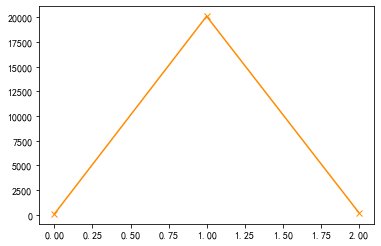

In [182]:
#china
#0217 是最原始的版本
##0218是改了Loss的全国模型与参数  死亡率除100
#02-19里面存的是  第二版loss  死亡率除10   治愈率乘2
#i=2  深圳  1 武汉   0 湖北
i=3
data=read_data(paths[i])
city_name=citys[i]
# param_path='models/'+'china/02-12'
datetime='02-21'
# param_path='models/shenzhen/02-17'
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]
model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=3,is_train=True,load_param_save=True,lr_init=0.00001,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)
# load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

data: [0.4732348482623374, 0.5346931660808585, 0.575890454913837, 0.6750040103483651, 0.7018009270279321, 0.7345470029713479, 0.6312820497562065, 0.5173705190579703, 0.3554383967480452, 0.3315220106030616, 0.32305735379332656, 0.3059337320972264, 0.2913337508792159, 0.28763029829873, 0.28437862286454146, 0.2813201266972328, 0.2749887873259114, 0.27333897183252487, 0.2713673307723122, 0.25077002607220833, 0.1307787491508388, 0.17973386229129903, 0.06488513675517213, 0.0495524937539759, 0.040434620352822644, 0.04042664116218998, 0.0364400177168582, 0.025933670727479298, 0.009797496865192028, 0.01247581040529364]
[-0.02439955 -0.05797865]
{'beta': [0.11057821565854775, 0.11000961100613857, 0.10944393017781913, 0.1088811581389827, 0.10832127993233216, 0.10776428067748227, 0.10721014557056432, 0.10665885988383264], 'gamma_2': [0.1889664595359614, 0.1909493684805905, 0.19291189651422877, 0.19485465945236388, 0.19677824270959657, 0.198683203360166, 0.2005700720223166, 0.2024393545845705], 'th

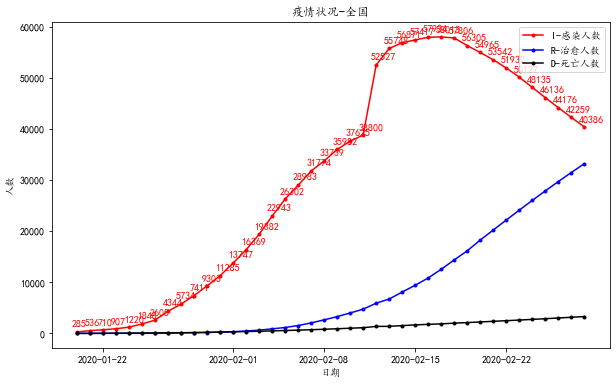

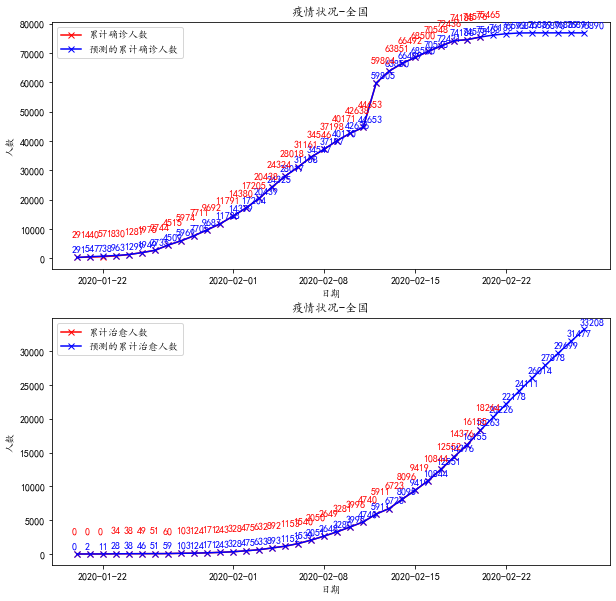

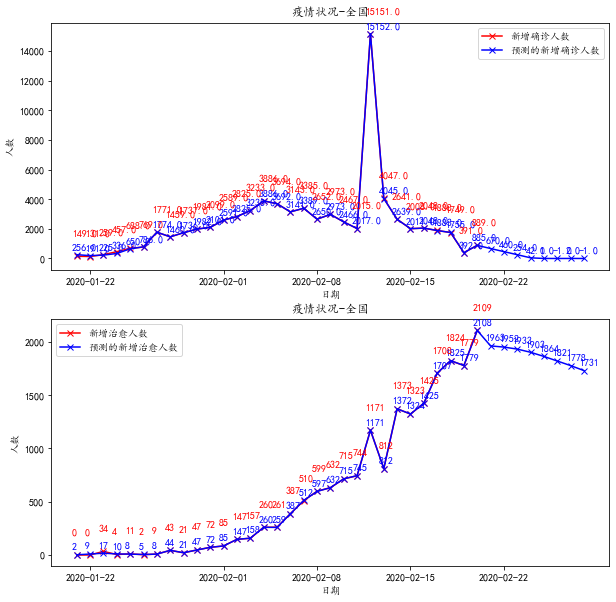

新增治愈： [   2    9   17   10    8    5    8   44   21   47   72   85  147  158
  260  259  387  512  597  632  715  745 1171  812 1372 1324 1425 1707
 1825 1779 2108 1963 1952 1933 1903 1864 1821 1778 1731]
新增确诊： [ 2.5600e+02  1.9100e+02  2.2500e+02  3.3600e+02  6.5000e+02  7.8600e+02
  1.7740e+03  1.4600e+03  1.7360e+03  1.9820e+03  2.1010e+03  2.5910e+03
  2.8250e+03  3.2350e+03  3.8860e+03  3.6920e+03  3.1410e+03  3.3890e+03
  2.6500e+03  2.9730e+03  2.4660e+03  2.0170e+03  1.5152e+04  4.0450e+03
  2.6390e+03  2.0110e+03  2.0480e+03  1.8830e+03  1.7550e+03  3.9200e+02
  8.8500e+02  6.7000e+02  4.6000e+02  2.5400e+02  4.2000e+01  1.0000e+00
 -1.0000e+00  2.0000e+00 -1.0000e+00]


In [183]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name,pred_date_len=8)
# plot_param(model,city_name,data,xlen=15)
# model_city_date_path 1618

data: [0.4731949523740559, 0.534650758584026, 0.5758464439806907, 0.674956362373581, 0.7017523424554789, 0.7344972978223023, 0.6312359707900141, 0.5173288041763292, 0.35540382108320284, 0.3314886184687726, 0.3230243907221936, 0.305901654544419, 0.29130244811680506, 0.2875991951393293, 0.2843476960210049, 0.28128936661712184, 0.2749583753654594, 0.2733086512412088, 0.27119258231147403, 0.2505626155305859, 0.13057230602476688, 0.17942586563504198, 0.06440101627690728, 0.04831682088692177, 0.038285389823162784, 0.03626754423956725, 0.03241280657312383, 0.022092498108180522, 0.002796137687246746]
[-0.01104953 -0.02640573]
{'beta': [0.052349733020050214, 0.05208054526394196, 0.05181274169919168, 0.05154631520814386, 0.051281258709742726, 0.051017565159344, 0.05075522754852771, 0.05049423890491192], 'gamma_2': [0.17701538405289335, 0.17878127602666616, 0.18052989537484548, 0.18226173923888228, 0.1839772813602592, 0.1856769735940395, 0.18736124729882458, 0.18903051461523604], 'theta': [0.0522

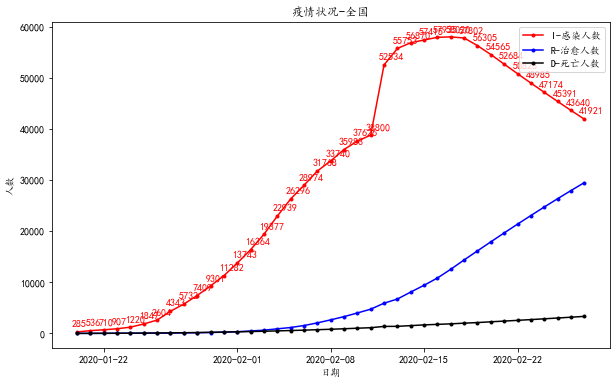

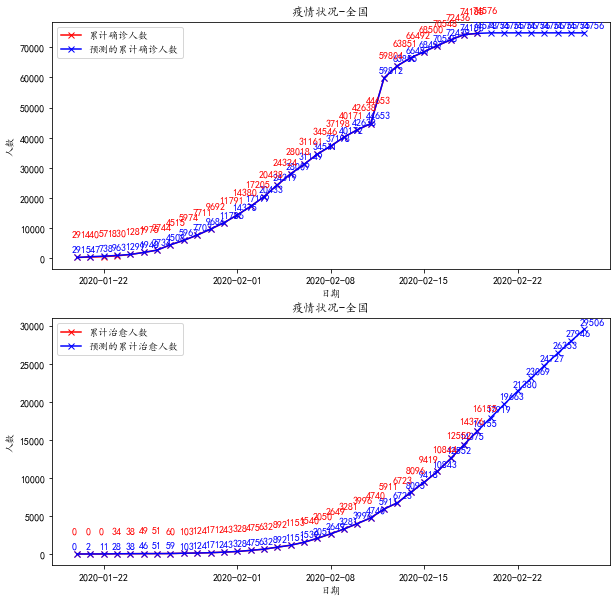

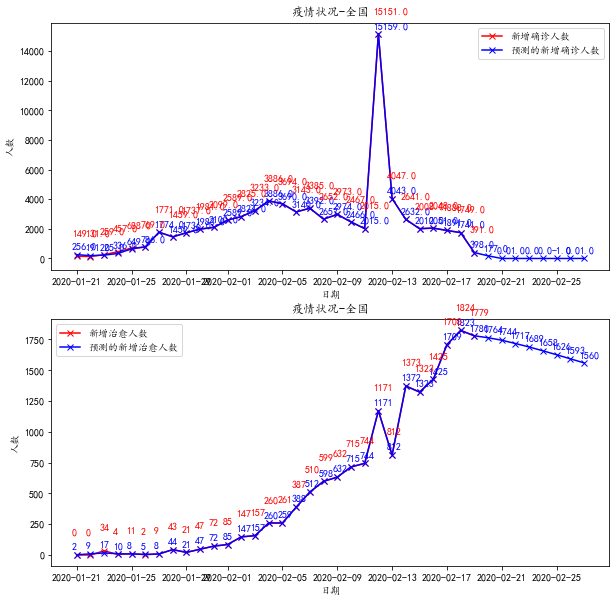

新增治愈： [   2    9   17   10    8    5    8   44   21   47   72   85  147  157
  260  259  388  512  598  632  715  744 1171  812 1372 1323 1425 1709
 1823 1780 1764 1744 1717 1689 1658 1626 1593 1560]
新增确诊： [ 2.5600e+02  1.9100e+02  2.2500e+02  3.3600e+02  6.4900e+02  7.8600e+02
  1.7740e+03  1.4590e+03  1.7360e+03  1.9830e+03  2.1000e+03  2.5890e+03
  2.8240e+03  3.2340e+03  3.8860e+03  3.6900e+03  3.1400e+03  3.3920e+03
  2.6570e+03  2.9740e+03  2.4660e+03  2.0150e+03  1.5159e+04  4.0430e+03
  2.6320e+03  2.0100e+03  2.0510e+03  1.8910e+03  1.7410e+03  3.9800e+02
  1.7700e+02  0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00 -1.0000e+00
  0.0000e+00  1.0000e+00]
./ncov/com_pred/china\02-21


In [162]:
model,new_C,new_R = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name,return_new_C_R=True, pred_date_len=8)
new_R_pred = new_R[-7:]
new_C_pred = new_C[-7:]
sample = pd.read_csv('./ncov/data/sample.csv')
for i in range(7): 
    C_name = 'confirmed_day'+str(i+1)
    R_name = 'recovery_day'+str(i+1)
    sample[C_name] = new_C_pred[i].astype(int)
    sample[R_name] = new_R_pred[i].astype(int)
def make_pred_dir(date, city='china'):
    save_root_path = './ncov/com_pred/'
    model_city_path = os.path.join(save_root_path, city)
    model_city_date_path = os.path.join(model_city_path, date)
    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path
pred_dir = make_pred_dir('02-21')
submission_path = os.path.join(pred_dir,'submission_arima_19.csv')
sample.to_csv(submission_path,index=False)

In [138]:
import datetime
'''
1.某个地方第一次训练设置load_param=False,之后默认为True  
2.默认使用参数预测，use_param_pred=false
3.param_date指定加载哪一天的模型参数,默认为''
4.多次训练的时候可指定训练轮数和学习率，默认为2000,0.001
'''
def train_predict(N_init,city_name,param_date='',load_param=True,use_param_pred=True,eprochs=2000,lr_rate=0.001):
    def get_today():
        today = datetime.datetime.today()
        today+=datetime.timedelta(days=-2)
        format_datetime = lambda x :f'0{x.month}{x.day}' if x.month<10 else f'{x.month}-{x.day}'
        return format_datetime(today)
    city_pinyins={'北京':'beijing', '上海':'shanghai', '重庆':'chongqing'}
    #获取今日日期的字符串  '02-13'格式
    model_save_time=get_today()
    city_pinyin=city_pinyins[city_name]
    data=read_data('./ncov/data/'+city_pinyin+'_截至'+model_save_time+'_24时.csv')  ##这里需要把allcity里面的update_time 改成time
    param_path=''
    #默认为空 直接加载最近的参数 如果指定日期，则会加载指定日期的参数
    if param_date!='':
        param_path='models/'+city_pinyin+'/'+param_date
    model_city_date_path = train_with_city_data(data,N_init,model_save_time,city_name,max_epoches=eprochs,is_train=True,load_param_save=load_param,lr_init=lr_rate,param_path=param_path)
    model = load_model_predict(model_city_date_path, data, param_pred=use_param_pred, city_name=city_name,pred_date_len=5)
    plot_param(model,city_name,data,xlen=15)

In [16]:
def format_output(model_city_date_path, data, param_pred=False, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5, data_dict={'累计':{},'新增':{}},data_dict_report={'累计':{},'新增':{}}):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])

        param = model.param_pred(beta,gamma_2,theta,alpha)

#         print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    # plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    # plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

    T_name = 'time'
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    # pd.to_datetime()
    def format_datetime(x):
        xd = x.date()
        fxd = ''
        if xd.month<10 and xd.day<10:
            fxd = f'0{xd.month}-0{xd.day}'
        elif xd.month<10 and xd.day>=10: 
            fxd = f'0{xd.month}-{xd.day}'
        else:
            fxd = f'{xd.month}-{xd.day}'
        return fxd
    dates_list = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    data_dict_report['累计'][city_name] = dict.fromkeys(dates_list)
    data_dict_report['新增'][city_name] = dict.fromkeys(dates_list)
    temp=[]
    for i,p in enumerate(confirm_pred):
        data_dict['累计'][city_name].append([dates_list[i],p])
        data_dict_report['累计'][city_name][dates_list[i]]=p
    for i,p in enumerate(new_confirm_pred_total):
        data_dict['新增'][city_name].append([dates_list[i+1],p])
        data_dict_report['新增'][city_name][dates_list[i+1]]=p
    return data_dict,data_dict_report

cured_ratio: 4.6625
dead_ratio: 186.5
{'beta': [1.1144036673161293, 1.0313712742559524, 0.9440478628729808, 0.7392976878675228, 0.6549396559330318, 0.6249162761748509, 0.5688449805350521, 0.549097888971826, 0.5423572551867236, 0.5298103579456542, 0.5337236052059547, 0.4527958824210194, 0.42337530364707454, 0.4342297419034859, 0.41621180027949667, 0.41148633369029364, 0.38080570962513455, 0.3332032762324669, 0.3425667127573697, 0.3346689006017409, 0.2649156173240452, 0.26452654033584444, 0.25130252544778575, 0.23613569550193084, 0.19995002673285134, 0.19674105909428388, 0.19667111449934102], 'theta': [-6.186870448159784e-06, 8.532919709545764e-06, -0.00019515736629323595, 0.0004303652831614029, -0.17398172568562645, -0.0005213921612508391, 8.327109241288152e-06, -1.9316829392759105e-05, 1.4573753690809278e-05, 9.424978868173384e-06, 7.72838064144831e-06, -7.14569381063755e-06, 6.8120241180138894e-06, 6.535928373884283e-06, -6.327529226134537e-06, 6.186062979900576e-06, 6.156385408427503

Training step:  129
Loss: 0.016838100223240348
Training step:  130
Loss: 0.01679172270134777
Training step:  131
Loss: 0.01676261813284692
Training step:  132
Loss: 0.01671520914371254
Training step:  133
Loss: 0.016680585642812863
Training step:  134
Loss: 0.016638939348286294
Training step:  135
Loss: 0.016599256089774885
Training step:  136
Loss: 0.0165558721477993
Training step:  137
Loss: 0.01652517339956195
Training step:  138
Loss: 0.016480750043164936
Training step:  139
Loss: 0.01644476012756277
Training step:  140
Loss: 0.016406011648605758
Training step:  141
Loss: 0.016365065865989813
Training step:  142
Loss: 0.01632451077012013
Training step:  143
Loss: 0.016292377132766427
Training step:  144
Loss: 0.016250729032294277
Training step:  145
Loss: 0.016213553401038475
Training step:  146
Loss: 0.016177450994814303
Training step:  147
Loss: 0.01614236081631499
Training step:  148
Loss: 0.016104726797963057
Training step:  149
Loss: 0.016065002436032354
Training step:  150
Lo

Training step:  307
Loss: 0.011543485994222126
Training step:  308
Loss: 0.011514188350541216
Training step:  309
Loss: 0.01150296380187029
Training step:  310
Loss: 0.011471961499573328
Training step:  311
Loss: 0.011459196425827352
Training step:  312
Loss: 0.011429881897814319
Training step:  313
Loss: 0.011415889587610034
Training step:  314
Loss: 0.011388250488335054
Training step:  315
Loss: 0.011376194879639685
Training step:  316
Loss: 0.011346873060272591
Training step:  317
Loss: 0.011333482159115138
Training step:  318
Loss: 0.011305815163646362
Training step:  319
Loss: 0.01129603446076413
Training step:  320
Loss: 0.011265054673849586
Training step:  321
Loss: 0.011253939459117148
Training step:  322
Loss: 0.011224594673090811
Training step:  323
Loss: 0.011217119043149712
Training step:  324
Loss: 0.011184504285164345
Training step:  325
Loss: 0.011175634169980048
Training step:  326
Loss: 0.011144638851915693
Training step:  327
Loss: 0.011137879191119797
Training step: 

Training step:  482
Loss: 0.008948153278063791
Training step:  483
Loss: 0.008946256919234077
Training step:  484
Loss: 0.008929088531697674
Training step:  485
Loss: 0.008926470922025425
Training step:  486
Loss: 0.008911606470035641
Training step:  487
Loss: 0.008910660239670397
Training step:  488
Loss: 0.008894329585371112
Training step:  489
Loss: 0.00889130471949421
Training step:  490
Loss: 0.00887595897753468
Training step:  491
Loss: 0.008875975437631306
Training step:  492
Loss: 0.008859175473479537
Training step:  493
Loss: 0.008857051329192362
Training step:  494
Loss: 0.008842529961681608
Training step:  495
Loss: 0.008838447723424864
Training step:  496
Loss: 0.00882487617772734
Training step:  497
Loss: 0.008823695552080735
Training step:  498
Loss: 0.008808674526168798
Training step:  499
Loss: 0.00880551806550757
Training step:  500
Loss: 0.008792746205535001
Training step:  501
Loss: 0.008791234486101451
Training step:  502
Loss: 0.008775713891281086
Training step:  5

Loss: 0.008135035286048363
Training step:  661
Loss: 0.008135904199992891
Training step:  662
Loss: 0.008133521370422305
Training step:  663
Loss: 0.008135076289304833
Training step:  664
Loss: 0.008133062172711059
Training step:  665
Loss: 0.008134255391294355
Training step:  666
Loss: 0.008131568388226821
Training step:  667
Loss: 0.008133448625807154
Training step:  668
Loss: 0.008131124652352963
Training step:  669
Loss: 0.008132645712867636
Training step:  670
Loss: 0.00813069212422011
Training step:  671
Loss: 0.008131856029393031
Training step:  672
Loss: 0.00812923199602109
Training step:  673
Loss: 0.008131074569577783
Training step:  674
Loss: 0.008128814401646894
Training step:  675
Loss: 0.008130302604262087
Training step:  676
Loss: 0.00812737348085829
Training step:  677
Loss: 0.008129541743062612
Training step:  678
Loss: 0.008126971777913819
Training step:  679
Loss: 0.008128787146350687
Training step:  680
Loss: 0.008125558872922654
Training step:  681
Loss: 0.00812804

Training step:  837
Loss: 0.008094238479127998
Training step:  838
Loss: 0.008093270610656917
Training step:  839
Loss: 0.008094154635376556
Training step:  840
Loss: 0.008093188055696664
Training step:  841
Loss: 0.008094071026325637
Training step:  842
Loss: 0.008093105730832426
Training step:  843
Loss: 0.008093987649156585
Training step:  844
Loss: 0.008093023507566294
Training step:  845
Loss: 0.008093904498779492
Training step:  846
Loss: 0.008092936309644005
Training step:  847
Loss: 0.008093821549394656
Training step:  848
Loss: 0.008092043809403324
Training step:  849
Loss: 0.008093477789534061
Training step:  850
Loss: 0.00809196167877901
Training step:  851
Loss: 0.0080933950254328
Training step:  852
Loss: 0.00809188150411956
Training step:  853
Loss: 0.008093312500852422
Training step:  854
Loss: 0.008091801058109825
Training step:  855
Loss: 0.008093230207711551
Training step:  856
Loss: 0.008091720947218481
Training step:  857
Loss: 0.008093148147530775
Training step:  8

Loss: 0.008082109176333018
Training step:  1014
Loss: 0.008076112194599961
Training step:  1015
Loss: 0.008082040764390869
Training step:  1016
Loss: 0.008076052937970498
Training step:  1017
Loss: 0.008081972550401361
Training step:  1018
Loss: 0.008075993532077991
Training step:  1019
Loss: 0.008081904526459594
Training step:  1020
Loss: 0.008075934594367012
Training step:  1021
Loss: 0.008081836698364991
Training step:  1022
Loss: 0.008075875626595385
Training step:  1023
Loss: 0.00808176905574273
Training step:  1024
Loss: 0.008075817032878482
Training step:  1025
Loss: 0.008081701610702157
Training step:  1026
Loss: 0.008075758210033469
Training step:  1027
Loss: 0.008081634345152758
Training step:  1028
Loss: 0.008075700103337958
Training step:  1029
Loss: 0.008081567278883572
Training step:  1030
Loss: 0.008075641711309868
Training step:  1031
Loss: 0.008081500400141474
Training step:  1032
Loss: 0.008075583578880198
Training step:  1033
Loss: 0.008081433706437985
Training step:

Training step:  1187
Loss: 0.008071031373531901
Training step:  1188
Loss: 0.008063670225911281
Training step:  1189
Loss: 0.008070976495872103
Training step:  1190
Loss: 0.008063626124114407
Training step:  1191
Loss: 0.00807092176032832
Training step:  1192
Loss: 0.008063582457194442
Training step:  1193
Loss: 0.008070867172850776
Training step:  1194
Loss: 0.008063539009524768
Training step:  1195
Loss: 0.008070812729700352
Training step:  1196
Loss: 0.008063495412852046
Training step:  1197
Loss: 0.008070758424195005
Training step:  1198
Loss: 0.008063452017567108
Training step:  1199
Loss: 0.008070704251379481
Training step:  1200
Loss: 0.0080634086052882
Training step:  1201
Loss: 0.008070650200514123
Training step:  1202
Loss: 0.008063365674953409
Training step:  1203
Loss: 0.008070596259917217
Training step:  1204
Loss: 0.008063322509391128
Training step:  1205
Loss: 0.00807054239595201
Training step:  1206
Loss: 0.008063279390097886
Training step:  1207
Loss: 0.008070488525878

Loss: 0.008062380873250119
Training step:  1362
Loss: 0.008052410835814532
Training step:  1363
Loss: 0.008062335295529514
Training step:  1364
Loss: 0.008052380104406665
Training step:  1365
Loss: 0.008062289833566359
Training step:  1366
Loss: 0.0080523493110517
Training step:  1367
Loss: 0.00806224448296678
Training step:  1368
Loss: 0.008052318943102828
Training step:  1369
Loss: 0.008062199243875245
Training step:  1370
Loss: 0.008052288342299648
Training step:  1371
Loss: 0.008062154107668683
Training step:  1372
Loss: 0.008052257831811384
Training step:  1373
Loss: 0.00806210906427489
Training step:  1374
Loss: 0.008052227548453065
Training step:  1375
Loss: 0.008062064098667436
Training step:  1376
Loss: 0.008052197243233335
Training step:  1377
Loss: 0.008062019187271447
Training step:  1378
Loss: 0.008052167111537846
Training step:  1379
Loss: 0.008061974244633485
Training step:  1380
Loss: 0.008052135373598633
Training step:  1381
Loss: 0.00806192870365043
Training step:  13

Loss: 0.008039348533050073
Training step:  1705
Loss: 0.008050638402334852
Training step:  1706
Loss: 0.008039333979909576
Training step:  1707
Loss: 0.008050005395877646
Training step:  1708
Loss: 0.008039355545882353
Training step:  1709
Loss: 0.008049902708443768
Training step:  1710
Loss: 0.008039340710589805
Training step:  1711
Loss: 0.008049872105274088
Training step:  1712
Loss: 0.008039325798552802
Training step:  1713
Loss: 0.008049841580007593
Training step:  1714
Loss: 0.00803931085199398
Training step:  1715
Loss: 0.008049811133004738
Training step:  1716
Loss: 0.008039295828386866
Training step:  1717
Loss: 0.008049780760456546
Training step:  1718
Loss: 0.008039280576401167
Training step:  1719
Loss: 0.008049750466412946
Training step:  1720
Loss: 0.00803903940000823
Training step:  1721
Loss: 0.008049651667531495
Training step:  1722
Loss: 0.008039025057618223
Training step:  1723
Loss: 0.008049621416089975
Training step:  1724
Loss: 0.008039010524858205
Training step: 

Training step:  1878
Loss: 0.008031885589663513
Training step:  1879
Loss: 0.008042538698013833
Training step:  1880
Loss: 0.00803187420273855
Training step:  1881
Loss: 0.008042512736866746
Training step:  1882
Loss: 0.008031862943036799
Training step:  1883
Loss: 0.008042486778693719
Training step:  1884
Loss: 0.008031851744404107
Training step:  1885
Loss: 0.00804246075024588
Training step:  1886
Loss: 0.008031840689345364
Training step:  1887
Loss: 0.008042434152613489
Training step:  1888
Loss: 0.008031829756686508
Training step:  1889
Loss: 0.00804194927194594
Training step:  1890
Loss: 0.008031846400750667
Training step:  1891
Loss: 0.008041710759195393
Training step:  1892
Loss: 0.008031657273329058
Training step:  1893
Loss: 0.008041531582645494
Training step:  1894
Loss: 0.008031469670988802
Training step:  1895
Loss: 0.008041505887027954
Training step:  1896
Loss: 0.008031458732178632
Training step:  1897
Loss: 0.008041481001147365
Training step:  1898
Loss: 0.00803144793081

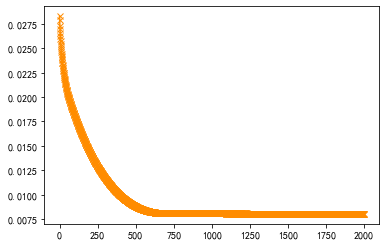

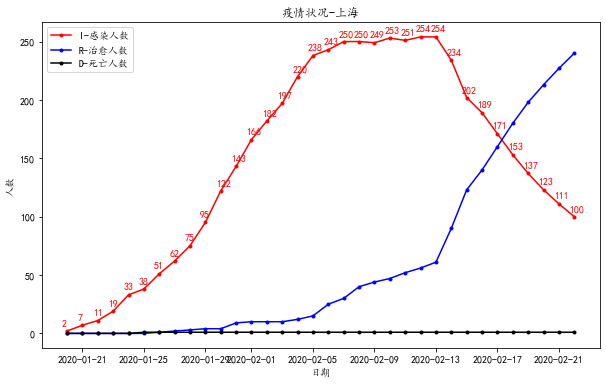

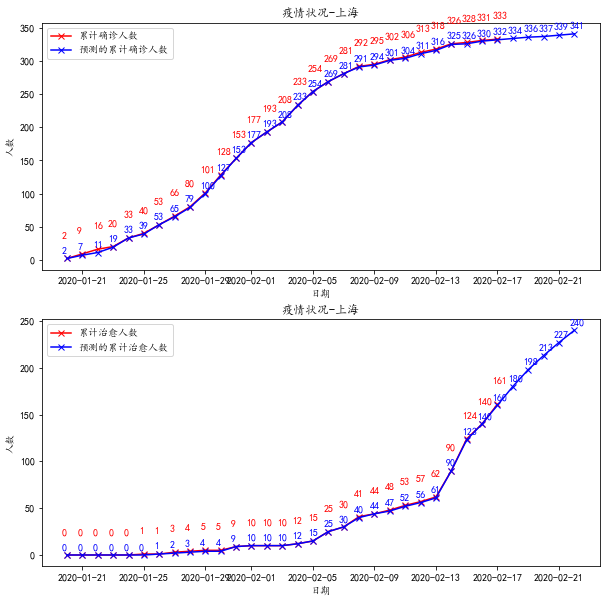

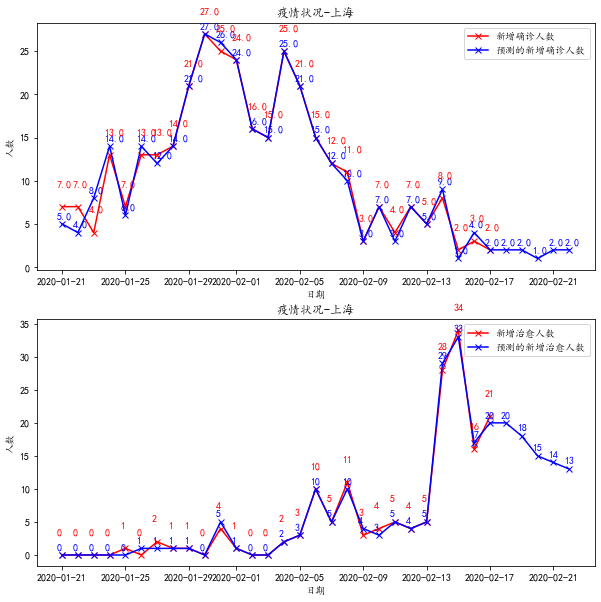

新增治愈： [ 0  0  0  0  0  1  1  1  1  0  5  1  0  0  2  3 10  5 10  4  3  5  4  5
 29 33 17 20 20 18 15 14 13]
新增确诊： [ 5.  4.  8. 14.  6. 14. 12. 14. 21. 27. 26. 24. 16. 15. 25. 21. 15. 12.
 10.  3.  7.  3.  7.  5.  9.  1.  4.  2.  2.  2.  1.  2.  2.]
beta: [1.114430758150335, 1.0313983622922342, 0.944074949756139, 0.739324775163049, 0.654966744010082, 0.6249433641971783, 0.568872068863025, 0.5491249775768935, 0.5423843440630451, 0.5298374472942922, 0.5337506951094759, 0.4528229726914416, 0.42340239462065293, 0.43425683351320504, 0.4160988934163606, 0.4113734293185983, 0.3806928103593951, 0.3329505974448424, 0.3418959332829324, 0.33372018553694577, 0.2620461857993404, 0.26084600351362325, 0.24575730200916804, 0.22647123391280002, 0.16807786924801713, 0.16044313572853244, 0.15189747388521274, 0.1818759091922378]
gamma_2: [-6.154907585661412e-05, 8.532062659925808e-05, 0.00024475620154740404, 0.019324277881804103, -0.1646117134587971, 0.0698599235599179, 0.19312958560784976, 0.1270607615465

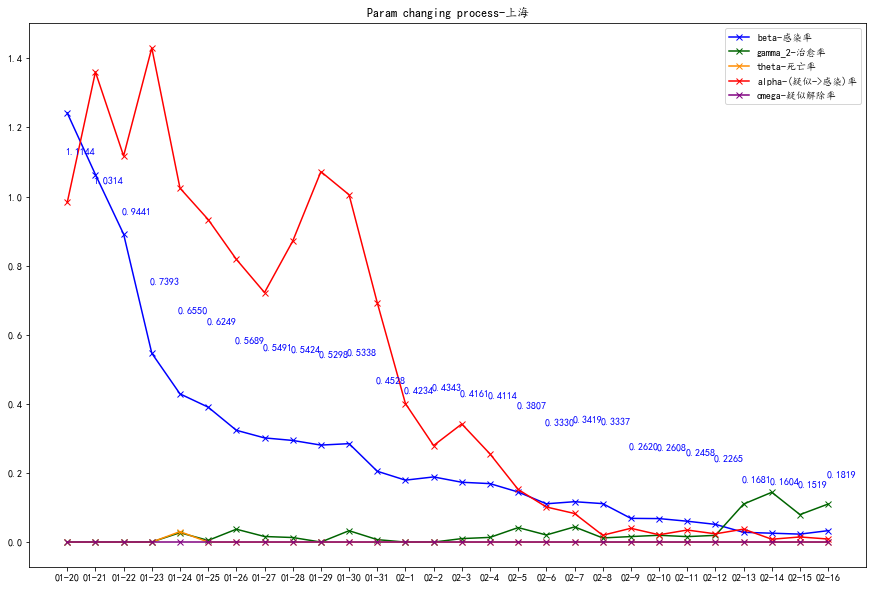

In [149]:
other_citys=['北京','上海']
populatinos=[21540000.,24240000.,30480000.]
param_date='0216'  #指定日期则加载指定日期的参数
# for i in range(len(other_citys)):
i=1
city_name=other_citys[i]
N=populatinos[i]
#第一次训练
# train_predict(N,city_name,param_date=param_date,load_param=False,lr_rate=0.01)
train_predict(N,city_name,param_date=param_date,load_param=True,eprochs=2000,lr_rate=0.00007)

In [140]:
time='0217'
citys=['北京','上海']
paths=['./ncov/data/beijing_截至'+time+'_24时.csv','./ncov/data/shanghai_截至'+time+'_24时.csv']
modelpath=['./models/beijing/'+time,'./models/shanghai/'+time]

def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict_report = init_data_dict(citys)
for i in range(len(citys)):
    city_name=citys[i]
    print(city_name)
    data=read_data(paths[i])
    data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print(data_dict)

北京


FileNotFoundError: [Errno 2] No such file or directory: './models/beijing/0217\\model.pt'

In [ ]:
for i in range(len(citys)):
    city_name=citys[i]
    if city_name=='全国':
        continue
    data=read_data(paths[i])
    if city_name=='深圳':
        data_dict = format_output(modelpath[i], data, param_pred=False, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)
    else:
        data_dict = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)

In [222]:
def exponential_decay(t, init=0.8, m=30, finish=0.2):
    alpha = np.log(init / finish) / m
    l = - np.log(init) / alpha
    decay = np.exp(-alpha * (t + l))
    return decay

In [224]:
del exponential_decay

In [81]:
c=[0.3568949200423759, 0.3700824862403864, 0.4638453133348259, 0.4689212149807485, 0.7045515259123547, 0.5178571957749054, 0.5320025639278643, 0.6324220356643714, 0.4619751971838374, 0.4783207759398565, 0.4125839150593981, 0.3669642655548194, 0.3128453296326513, 0.1716549677065777, 0.21425126523968718, 0.2572809221472783, 0.17094883154763663, 0.21685174991821732, 0.17198455143137334, 0.19091312827789256, 0.06544681594621296, 0.06984275712449138, 0.08188034108307844]
m=smt.ARIMA(c,order=(1,0,1)).fit()

In [83]:
m.forecast(7)

(array([0.10187225, 0.11682335, 0.13052377, 0.14307813, 0.1545823 ,
        0.16512413, 0.17478412]),
 array([0.08874463, 0.10803856, 0.1219033 , 0.13242898, 0.14066027,
        0.147217  , 0.15250507]),
 array([[-0.07206403,  0.27580854],
        [-0.09492833,  0.32857503],
        [-0.10840231,  0.36944986],
        [-0.1164779 ,  0.40263416],
        [-0.12110677,  0.43027137],
        [-0.12341589,  0.45366414],
        [-0.12412032,  0.47368856]]))